# Word Representation in Biomedical Domain

Before you start, please make sure you have read this notebook. You are encouraged to follow the recommendations but you are also free to develop your own solution from scratch. 

## Marking Scheme

- Biomedical imaging project: 40%
    - 20%: accuracy of the final model on the test set
    - 20%: rationale of model design and final report
- Natural language processing project: 40%
    - 30%: completeness of the project
    - 10%: final report
- Presentation skills and team work: 20%


This project forms 40\% of the total score for summer school. The marking scheme of each part of this project is provided below with a cap of 100\%.

You are allowed to use open source libraries as long as the libraries are properly cited in the code and final report. The usage of third-party code without proper reference will be treated as plagiarism, which will not be tolerated.

You are encouraged to develop the algorithms by yourselves (without using third-party code as much as possible). We will factor such effort into the marking process.

## Setup and Prerequisites 

Recommended environment

- Python 3.7 or newer
- Free disk space: 100GB

Download the data

```sh
# navigate to the data folder
cd data

# download the data file
# which is also available at https://www.semanticscholar.org/cord19/download
wget https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2021-07-26/document_parses.tar.gz

# decompress the file which may take several minutes
tar -xf document_parses.tar.gz

# which creates a folder named document_parses
```

## Part 1 (20%): Parse the Data

The JSON files are located in two sub-folders in `document_parses`. You will need to scan all JSON files and extract text (i.e. `string`) from relevant fields (e.g. body text, abstract, titles).

You are encouraged to extract full article text from body text if possible. If the hardware resource is limited, you can extract from abstract or titles as alternatives. 

Note: The number of JSON files is around 425k so it may take more than 10 minutes to parse all documents.

For more information about the dataset: https://www.semanticscholar.org/cord19/download

Recommended output:

- A list of text (`string`) extracted from JSON files.

In [4]:
!yum -y install unzip zip#根据数据集不同而改变
!unzip document_parses_mini.zip


/bin/bash: yum: command not found
Archive:  document_parses_mini.zip
   creating: pdf_json/
  inflating: pdf_json/0000028b5cc154f68b8a269f6578f21e31f62977.json  
  inflating: pdf_json/0000b93c66f991236db92dc16fa6db119b27ca12.json  
  inflating: pdf_json/0000fcce604204b1b9d876dc073eb529eb5ce305.json  
  inflating: pdf_json/000122a9a774ec76fa35ec0c0f6734e7e8d0c541.json  
  inflating: pdf_json/00013694fb8095bb818b64346f791a5419d97c88.json  
   creating: pmc_json/
  inflating: pmc_json/PMC1054884.xml.json  
  inflating: pmc_json/PMC1065028.xml.json  
  inflating: pmc_json/PMC1065064.xml.json  
  inflating: pmc_json/PMC1065120.xml.json  
  inflating: pmc_json/PMC1065257.xml.json  


In [1]:
!pip install tokenizers
!pip install gensim
!pip install --upgrade gensim


In [2]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

from gensim.test.utils import common_texts
from gensim.models import Word2Vec

import tensorflow as tf
import os
import json

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling
import matplotlib.pyplot as plt
import random

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.pre_tokenizer = Whitespace()
filelist = []
filelist1 = []
data = []
g = os.walk(r"/content/pdf_json")  
for path,dir_list,file_list in g:  
    for file_name in file_list: 
        filelist.append(os.path.join(path,file_name))
        filelist1.append(os.path.join(path,file_name))
 
for file in filelist:
    with open(file,'r') as f:
        temdata = json.load(f)
        text = ""
        for part in temdata['body_text']:
            text = text + part['text']
        data.append(text)

filelist = []
g = os.walk(r"/content/pmc_json")  
for path,dir_list,file_list in g:  
    for file_name in file_list: 
        filelist.append(os.path.join(path,file_name))
        filelist1.append(os.path.join(path,file_name))
for file in filelist:
    with open(file,'r') as f:
        temdata = json.load(f)
        text = ""
        for part in temdata['body_text']:
            text = text + part['text']
        data.append(text)

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Part 2 (30%): Tokenization

Traverse the extracted text and segment the text into words (or tokens).

The following tracks can be developed in independentely. You are encouraged to divide the workload to each team member.

Recommended output:

- Tokenizer(s) that is able to tokenize any input text.

Note: Because of the computation complexity of tokenizers, it may take hours/days to process all documents. Which tokenizer is more efficient? Any idea to speedup?

### Track 2.1 (10%): Use split()

Use the standard `split()` by Python.
```
data_split = []
for piece in data:
    if(len(piece)>0):
        data_split.append(piece.split())
        data.remove(piece)
print(data_split)
```

### Track 2.2 (10%): Use NLTK or SciSpaCy

NLTK tokenizer: https://www.nltk.org/api/nltk.tokenize.html

SciSpaCy: https://github.com/allenai/scispacy

Note: You may need to install NLTK and SpaCy so please refer to their websites for installation instructions.

```
data_split = []
for piece in data:
    if(len(piece)>0):
        data_split.append(sent_tokenize(piece))
        data.remove(piece)
print(data_split)
```

### Track 2.3 (10%): Use Byte-Pair Encoding (BPE)

Byte-Pair Encoding (BPE): https://huggingface.co/transformers/tokenizer_summary.html

Note: You may need to install Huggingface's transformers so please refer to its website for installation instructions.

```
data_split = []
files = filelist1
tokenizer.train(files, trainer)

for piece in data:
    if(len(piece)>0):
        output = tokenizer.encode(piece)
        data_split.append(output.tokens)
        data.remove(piece)
print(data_split[:3])
```

### Track 2.4 (Bonus +5%): Build new Byte-Pair Encoding (BPE)

This track may be dependent on track 2.3.

The above pre-built tokenization methods may not be suitable for biomedical domain as the words/tokens (e.g. diseases, sympotoms, chemicals, medications, phenotypes, genotypes etc.) can be very different from the words/tokens commonly used in daily life. Can you build and train a new BPE model for biomedical domain in particular?

### Open Question (Optional):

- What are the pros and cons of the above tokenizers?

In [11]:
data_split = []
files = filelist1
tokenizer.train(files, trainer)
data_split_id=[]
for piece in data:
    if(len(piece)>0):
        data_split.append(piece.split())
        data.remove(piece)
print(data_split)

[['Se', 'calcula', 'que', 'en', 'España', 'existen', 'cerca', 'de', '367.000', 'plazas', 'residenciales', 'para', 'personas', 'mayores', '(PPMM)', 'con', 'una', 'ocupación', 'del', '80%,', 'con', 'lo', 'que', 'casi', '300.000', 'personas', 'viven', 'en', 'ellas', '1', '.', 'Respecto', 'a', 'sus', 'características', 'clínicas,', 'el', 'estudio', 'de', 'la', 'Fundación', 'Edad', 'y', 'Vida,', 'sobre', 'casi', '20.000', 'personas,', 'residentes', 'en', '111', 'centros', 'de', '15', 'CCAA', '2', ',', 'las', 'describe', 'con', 'una', 'elevada', 'pluripatología', '(76%', 'de', 'los', 'casos', 'tienen', '≥3', 'diagnósticos', 'activos)', 'y', 'polifarmacia', '(el', '66%', 'toman', '≥7', 'fármacos),', 'inestabilidad', 'clínica', '(cada', 'año', 'el', '38%', 'son', 'derivadas', 'a', 'urgencias)', 'y', 'terminalidad', '(el', '43%', 'fallecen', 'durante', 'el', 'año).', 'Al', 'ingreso,', '63%', 'padecen', 'deterioro', 'cognitivo,', '45%', 'dependencia', 'severa', 'para', 'las', 'actividades', 'bás

## Part 3 (30%): Build Word Representations

Build word representations for each extracted word. If the hardware resource is limited, you may limit the vocabulary size up to 10k words/tokens (or even smaller) and the dimension of representations up to 256.

The following tracks can be developed independently. You are encouraged to divide the workload to each team member.

### Track 3.1 (15%): Use N-gram Language Modeling

N-gram Language Modeling is to predict a target word by using `n` words from previous context. Specifically,

$P(w_i | w_{i-1}, w_{i-2}, ..., w_{i-n+1})$

For example, given a sentence, `"the main symptoms of COVID-19 are fever and cough"`, if $n=7$, we use previous context `["the", "main", "symptoms", "of", "COVID-19", "are"]` to predict the next word `"fever"`.

More to read: https://web.stanford.edu/~jurafsky/slp3/3.pdf

Recommended outputs:

- A fixed vector for each word/token.
```
model = FastText(sentences=data_split, vector_size=50, window=5, min_count=10, workers=4,sg = 1,negative=8) 
#需要提前安装gensim，利用其提供的FastText完成基于字母的ngram
```

### Track 3.2 (15%): Use Skip-gram with Negative Sampling

In skip-gram, we use a central word to predict its context. Specifically,

$P(w_{c-m}, ... w_{c-1}, w_{c+1}, ..., w_{c+m} | w_c)$

As the learning objective of skip-gram is computational inefficient (summation of entire vocabulary $|V|$), negative sampling is commonly applied to accelerate the training.

In negative sampling, we randomly select one word from the context as a positive sample, and randomly select $K$ words from the vocabulary as negative samples. As a result, the learning objective is updated to

$L = -\log\sigma(u^T_{t} v_c) - \sum_{k=1}^K\log\sigma(-u^T_k v_c)$, where $u_t$ is the vector embedding of positive sample from context, $u_k$ are the vector embeddings of negative samples, $v_c$ is the vector embedding of the central word, $\sigma$ refers to the sigmoid function.

More to read http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf section 4.3 and 4.4

Recommended outputs:

- A fixed vector for each word/token.
```
model = Word2Vec(sentences=data_split, vector_size=50, window=5, min_count=10, workers=4,sg = 1,negative=8) 
#需要提前安装gensim，利用其提供的skip-gram接口
```


### Track 3.3 (Bonus +5%): Use Contextualised Word Representation by Masked Language Model (MLM)

BERT introduces a new language model for pre-training named Masked Language Model (MLM). The advantage of MLM is that the word representations by MLM will be contextualised.

For example, "stick" may have different meanings in different context. By N-gram language modeling and word2vec (skip-gram, CBOW), the word representation of "stick" is fixed regardless of its context. However, MLM will learn the representation of "stick" dynamatically based on context. In other words, "stick" will have different representations in different context by MLM.

More to read: http://jalammar.github.io/illustrated-bert/ and https://arxiv.org/pdf/1810.04805.pdf

Recommended outputs:

- An algorithm that is able to generate contextualised representation in real time.

```
from simpletransformers.language_representation import RepresentationModel
model = RepresentationModel(
        model_type="bert",
        model_name="bert-base-uncased",
        use_cuda=False
    )
word_vectors = model.encode_sentences(data, combine_strategy=None)# extra 5 points
```

In [69]:
#part3.1 ngram
#model = FastText(sentences=data_split, vector_size=50, window=5, min_count=10, workers=4,sg = 1,negative=8) 
# Part 3.2 skip-gram
model = Word2Vec(sentences=data_split,vector_size = 200,window=5, min_count=10, workers=4,sg = 1,negative=8)
'''
part 3.3 Bert
from simpletransformers.language_representation import RepresentationModel
model = RepresentationModel(
        model_type="bert",
        model_name="bert-base-uncased",
        use_cuda=False
    )
word_vectors = model.encode_sentences(data, combine_strategy=None)# extra 5 points
'''

can


In [62]:
for i in model.wv.index_to_key[:200]:
  print(i)

de
the
of
la
and
a
en
to
y
in
el
los
que
se
recombination
las
were
that
for
del
con
with
is
was
on
un
we
handheld
at
una
be
by
this
between
viral
para
CaMV
from
or
The
as
information
su
not
are
residencias
have
an
no
all
como
por
these
different
study
used
.
residentes
during
coordinación
host
DNA
frequency
each
rate
o
which
atención
Geriatría
markers
their
centros
entre
In
system
two
clinical
may
care
La
one
scenarios
más
such
r
been
es
access
pacientes
our
four
al
time
use
sus
those
using
Enlace
virus
critical
into
devices
who
fue
este
technology
medical
physicians
geriatras
En
visitas
had
single
actividad
other
frequencies
order
could
1
plants
can
han
sobre
Se
infected
participants
data
Atención
results
only
number
reference
loci
ten
We
per
plant
genomic
genome
population
situación
pandemia
cell
has
RNA
more
casos
ha
Hospital
área
servicio
fueron
servicios
when


## Part 4 (20%): Explore the Word Representations

The following tracks can be finished independently. You are encouraged to divide workload to each team member.

### Track 4.1 (5%): Visualise the word representations by t-SNE

t-SNE is an algorithm to reduce dimentionality and commonly used to visualise high-dimension vectors. Use t-SNE to visualise the word representations. You may visualise up to 1000 words as t-SNE is highly computationally complex.

More about t-SNE: https://lvdmaaten.github.io/tsne/

Recommende output:

- A diagram by t-SNE based on representations of up to 1000 words.

### Track 4.2 (5%): Visualise the Word Representations of Biomedical Entities by t-SNE

Instead of visualising the word representations of the entire vocabulary (or 1000 words that are selected at random), visualise the word representations of words which are biomedical entities. For example, fever, cough, diabetes etc. Based on the category of those biomedical entities, can you assign different colours to the entities and see if the entities from the same category can be clustered by t-SNE? For example, sinusitis and cough are both respirtory diseases so they should be assigned with the same colour and ideally their representations should be close to each other by t-SNE. Another example, Alzheimer and headache are neuralogical diseases which should be assigned by another colour.

Examples of biomedial ontology: https://www.ebi.ac.uk/ols/ontologies/hp and https://en.wikipedia.org/wiki/International_Classification_of_Diseases

Recommende output:

- A diagram with colours by t-SNE based on representations of biomedical entities.

### Track 4.3 (5%): Co-occurrence

- What are the biomedical entities which frequently co-occur with COVID-19 (or coronavirus)?

Recommended outputs:

- A sorted list of biomedical entities and description on how the entities are selected and sorted.

### Track 4.4 (5%): Semantic Similarity

- What are the biomedical entities which have closest semantic similarity COVID-19 (or coronavirus) based on word representations?

Recommended outputs:

- A sorted list of biomedical entities and description on how the entities are selected and sorted.

### Open Question (Optional): What else can you discover?


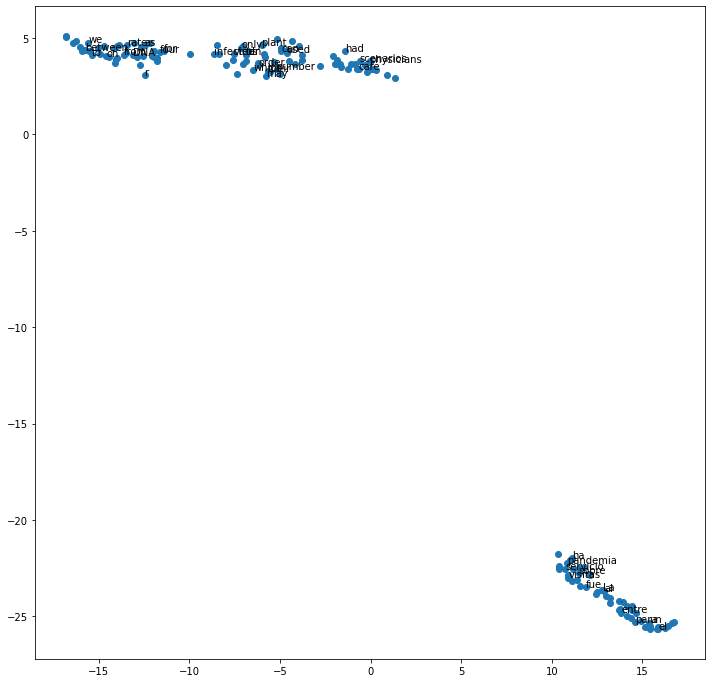

In [15]:
#4.1
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors[:200])
    labels = np.asarray(model.wv.index_to_key[:200])  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_matplotlib(x_vals, y_vals, labels):

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 100 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 40)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
x_vals, y_vals, labels = reduce_dimensions(model)

plot_with_matplotlib(x_vals, y_vals, labels)
plt.show()


In [19]:
#install new tookits to draw entity
!pip install scispacy
!pip install scispacy
!pip install  spacy

ERROR: Could not find a version that satisfies the requirement en_core_sci_sm (from versions: none)
ERROR: No matching distribution found for en_core_sci_sm


In [58]:
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz (125.1 MB)


In [88]:
#match entity
#Part 4.3
import scispacy
import spacy
import copy
nlp = spacy.load("en_ner_bionlp13cg_md")#load entity base
text =""
for i in data:
  text = text + i 

doc = nlp(text)

print(list(doc.ents))#create entity string from embedding type
ent_str = []
sim = []
for i in list(doc.ents):
  ent_str.append(str(i))

print(ent_str)
ent_str[0] = 'RNA'

result = model.wv.most_similar('can',topn = 100)
for i in result:
  if i[0] in ent_str:()# find most similar results that in entity list
    print (i[0])
    sim.append[i(0)]


[COVID-19, 2020.Most, COVID-19, coronavirus, COVID-19, patients, endotracheal tube, colorectal, patient, COVID-19 CT, patients, COVID-19, patient, COVID-19, COVID-19, patients, patient, coronavirus, COVID-19, COVID-19, patients, malignancies, cardiovascular, patients, COVID-19, people, patient, coronavirus, precancerous lesions, colorectal cancer, patients, office'-based, patient, patient, cardiac, ultra-rapid, ventricular, heart, CA, pulmonary, [4], heart, cerebrovascular, pulmonary embolism, glucose, [5], patients, CarE, glucose, [6], patient, glucose, glucose, Glucose, CA, [7], 15–100, glucose, [8]., HIV, WI, handhand, adenylate kinase, vancomycin-resistant enterococci, BacLite, UK, [9], midline cerebral, head injury patients [10].More, venous, venous, bloodstream, patients, [12], patients, FL, [13], renal, patients, US Centers, [14], intravascular, catheter-related BSI, tissue, [16], Endotoxin Adsorber, Fresenius, Bad, patients, lipopolysaccharide, UK, UK, [17].The, UK, extract, [1

<class 'list'>


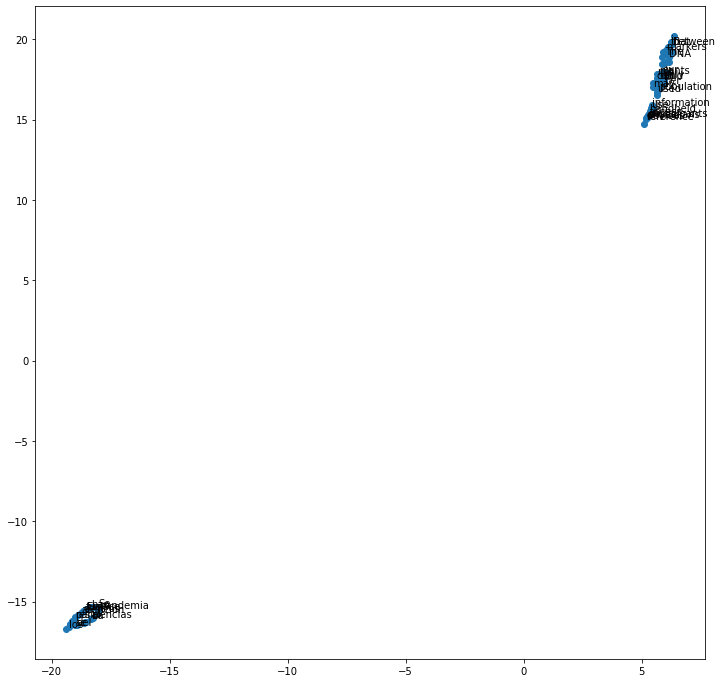

In [102]:
  #Part 4.2
  def entity_reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    tempa = copy.copy(model.wv.index_to_key[:1000])
    tempb  =copy.copy(model.wv.vectors[:1000].tolist())
    print(type(tempa))
    for i in tempa:
      if i not in  ent_str:#try to delete entity whicn are ot in the list
        del tempb[tempa.index(i)]
        del tempa[tempa.index(i)]
    
    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(tempb)
    labels = np.asarray(tempa)  # fixed-width numpy strings
 
     # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_entity_with_matplotlib(x_vals, y_vals, labels):

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 100 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 40)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
x_vals, y_vals, labels = entity_reduce_dimensions(model)

plot_entity_with_matplotlib(x_vals, y_vals, labels)
plt.show()


## Part 5 (Bonus +10%): Open Challenge: Mining Biomedical Knowledge

A fundamental task in clinical/biomedical natural language processing is to extract intelligence from biomedical text corpus automatically and efficiently. More specifically, the intelligence may include biomedical entities mentioned in text, relations between biomedical entities, clinical features of patients, progression of diseases, all of which can be used to predict, understand and improve patients' outcomes. 

This open challenge is to build a biomedical knowledge graph based on the CORD-19 dataset and mine useful information from it. We recommend the following steps but you are also encouraged to develop your solution from scratch.

### Extract Biomedical Entities from Text

Extract biomedical entities (such as fever, cough, headache, lung cancer, heart attack) from text. Note that:

- The biomedical entities may consist of multiple words. For example, heart attack, multiple myeloma etc.
- The biomedical entities may be written in synoynms. For example, low blood pressure for hypotension.
- The biomedical entities may be written in different forms. For example, smoking, smokes, smoked.

### Extract Relations between Biomedical Entities

Extract relations between biomedical entities based on their appearance in text. You may define a relation between biomedical entities by one or more of the following criteria:

- The biomedical entities frequentely co-occuer together.
- The biomedical entities have similar word representations.
- The biomedical entities have clear relations based on textual narratives. For example, "The most common symptoms for COVID-19 are fever and cough" so we know there are relations between "COVID-19", "fever" and "cough".

### Build a Biomedical Knowledge Graph of COVID-19

Build a knoweledge graph based on the results from track 5.1 and 5.2 and visualise it.

In [ ]:
###################
# TODO: add your solution

###################